#  IPython Notebook 3: Cliff Walking Environment (Without Importance Sampling Ratio)

# Experimental Results


In [39]:
#import the libraries

%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import pylab
#import gym_maze

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting

from lib.envs.windy_gridworld import WindyGridworldEnv
from lib.envs.cliff_walking import CliffWalkingEnv


matplotlib.style.use('ggplot')


In [40]:

#env = WindyGridworldEnv()
env = CliffWalkingEnv()


In [41]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    We choose an epsilon greedy policy here.
    This is a cool helper function adapted from the WildML blog. 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

# n-step SARSA

In [42]:
"""
n-step SARSA
"""
def n_sarsa(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
                
            next_action_probs = policy(next_state)  # Pick the next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                
            actions_list.append(next_action) # At+1
        
            
            
            tau = t-n+1
            
            """
            if tau == 0:
                G = 0
                G = sum(rewards_list[tau:tau+n]) + Q[states_list[tau+n-1]][actions_list[tau+n-1]]
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
                
               
            if done:
                break
            """
            if tau == 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + Q[states_list[tau+n-1]][actions_list[tau+n-1]]
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
            
            elif tau > 0:
                G = 0
                G = sum(rewards_list[tau:tau+n]) + Q[states_list[tau+n-1]][actions_list[tau+n-1]] # tau+n
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
                
                
            
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [43]:

#n step sarsa

n_episodes = 2000

alpha = 1
eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_sarsa = np.zeros([10])
for i in range(10):
    
    Q_sarsa, stats_sarsa = n_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_sarsa[i] = np.sum(stats_sarsa.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.1795 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.2555 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.269 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.2215 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.3045 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.1555 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.2015 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.157 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.2035 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -100.231 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4


# n-step expected sarsa

In [44]:
"""
n step expected SARSA
"""
def n_exp_sarsa(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
                
            next_action_probs = policy(next_state)  # Pick the next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                
            actions_list.append(next_action) # At+1
        
            
            
            tau = t-n+1
            
            if tau == 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
            elif tau > 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
                
           
                
            
            
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [45]:

#n expected step sarsa

n_episodes = 2000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_exp_sarsa = np.zeros([10])
for i in range(10):
    
    Q_exp_sarsa, stats_exp_sarsa = n_exp_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_exp_sarsa[i] = np.sum(stats_exp_sarsa.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_exp_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step expected SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.1745 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.205 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.189 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.183 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.1355 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.186 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.1905 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.192 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.16 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -100.2095 for alpha= 1.0 eps= 0.1 d

# Plots

# n-step tree backup

In [46]:
"""
n step tree backup
"""
def n_step_tree(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        delta_list = []
        pi_values = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
            
                
            next_action_probs = policy(next_state)  
            
            
            delta_list.append(reward + discount_factor * np.sum(next_action_probs * Q[next_state]) - Q[state][action]) #delta_t
            
            # Pick the next action At+1
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs) 
            
            actions_list.append(next_action) # At+1
        
            pi_values.append(next_action_probs[next_action])
            
            tau = t-n+1
            
            if tau == 0:
                
                E = 1
                G = Q[initial_state][initial_action]
                
                for k in range(n):
                    
                    G = G + E * delta_list[k]
                    E = discount_factor * E * pi_values[k]
                
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
            
            
            elif tau > 0:
                
                E = 1
                G = Q[states_list[tau-1]][actions_list[tau-1]]
                
                for k in range(n):
                    j = k + tau
                    G = G + E * delta_list[j]
                    E = discount_factor * E * pi_values[j]
                
                Q[states_list[tau-1]][actions_list[tau-1]] = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
                
                
            '''
            if tau == 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
           
            elif tau > 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
            '''
           
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
        
          
    
    return Q, stats

In [47]:
#n-step tree backup

n_episodes = 2000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_n_tree = np.zeros([10])
for i in range(10):
    
    Q_n_tree, stats_n_tree = n_step_tree(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_n_tree[i] = np.sum(stats_n_tree.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_n_tree[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step tree backup","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.137 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1965 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.177 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.159 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.176 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1905 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1735 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1965 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1975 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1305 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-

# n-step Q(sigma)

In [48]:
"""
n step Q(sigma)
"""

def n_step_q_sigma(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        delta_list = []
        pi_values = []
        sigma_values = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
            
                
            next_action_probs = policy(next_state)  
            
            
            
            # Pick the next action At+1
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs) 
            
            actions_list.append(next_action) # At+1
            
            # Store sigma values fo n=4
            
            if t==0:
                sigma_values.append(1)
            elif t==1:
                sigma_values.append(0)
            elif t%2 ==0 and t!=0:
                sigma_values.append(1)
            else:
                sigma_values.append(0)
                    
                    
            delta_list.append(reward + sigma_values[t]* Q[state][action] + discount_factor * (1 - sigma_values[t]) * np.sum(next_action_probs * Q[next_state]) - Q[state][action]) #delta_t

            
            pi_values.append(next_action_probs[next_action])
            
            tau = t-n+1
            
            if tau == 0:
                
                E = 1
                G = Q[initial_state][initial_action]
                
                for k in range(n):
                    
                    G = G + E * delta_list[k]
                    E = discount_factor * E * ((1-sigma_values[k])*pi_values[k] + sigma_values[k])
                
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
            
            
            elif tau > 0:
                
                E = 1
                G = Q[states_list[tau-1]][actions_list[tau-1]]
                
                for k in range(n):
                    j = k + tau
                    G = G + E * delta_list[j]
                    E = discount_factor * E * ((1-sigma_values[j])*pi_values[j] + sigma_values[j])
                
                Q[states_list[tau-1]][actions_list[tau-1]] = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
                
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [49]:
#n-step Q(sigma)

n_episodes = 2000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_n_sigma = np.zeros([10])
for i in range(10):
    
    Q_q_sigma, stats_q_sigma = n_step_q_sigma(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_n_sigma[i] = np.sum(stats_q_sigma.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_n_sigma[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step tree backup","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.1835 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.184 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.121 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1885 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.261 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.1985 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.242 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.217 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.2035 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -100.2645 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-s

In [50]:
#one step sarsa

n_episodes = 1500

alpha = 1
eps = 0.1
gamma = 1
n = 1

alpha = np.zeros([10])
alpha[0] = 0.1


#random_policy = create_random_policy(env.action_space.n)
#behaviour_policy = random_policy

avg_reward_sarsa_one = np.zeros([10])
for i in range(10):
    
    Q_sarsa_one, stats_sarsa_one = n_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_sarsa_one[i] = np.sum(stats_sarsa_one.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.1795 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.2555 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.269 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.2215 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.3045 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.1555 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.2015 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.157 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.2035 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -100.231 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1


In [51]:

#one step expected step sarsa

n_episodes = 1500

eps = 0.1
gamma = 1
n = 1

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_exp_sarsa_one = np.zeros([10])
for i in range(10):
    
    Q_exp_sarsa_one, stats_exp_sarsa_one = n_exp_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_exp_sarsa_one[i] = np.sum(stats_exp_sarsa_one.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_exp_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step expected SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -100.1745 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.205 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.189 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.183 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.1355 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.186 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.1905 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.192 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.16 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -100.2095 for alpha= 1.0 eps= 0.1 d

# PLOTS

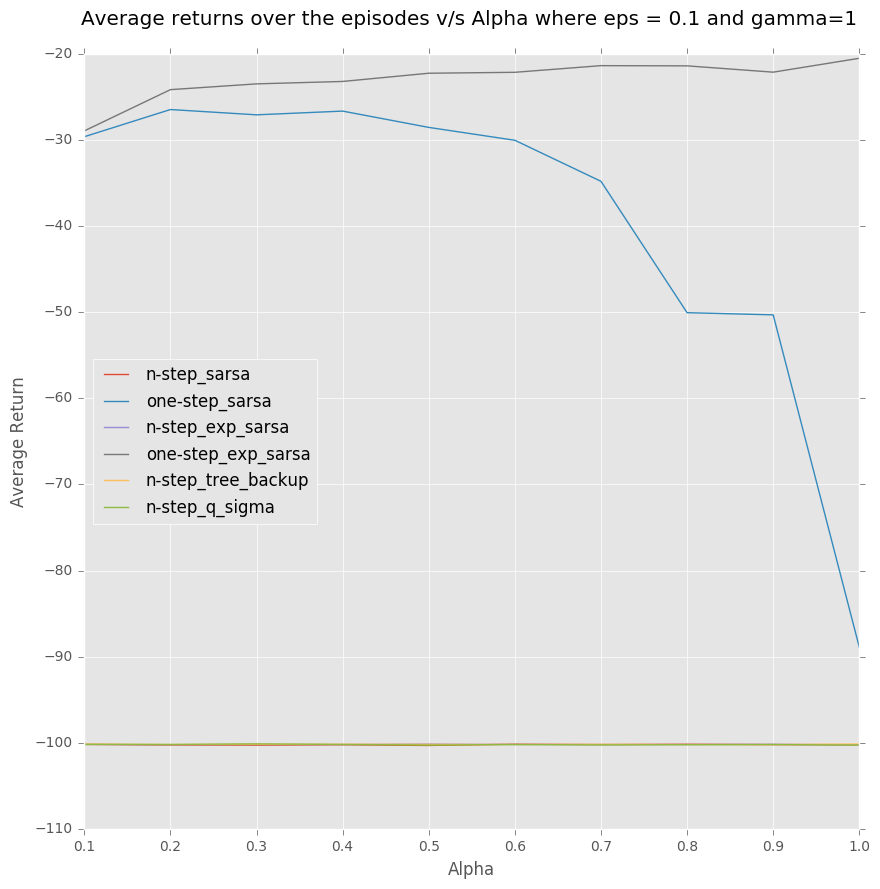

In [52]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))


plt.title("Average returns over the episodes v/s Alpha where eps = 0.1 and gamma=1 \n")
plt.xlabel('Alpha')
plt.ylabel('Average Return')


plt.plot(alpha, avg_reward_sarsa, label='n-step_sarsa')
plt.plot(alpha, avg_reward_sarsa_one, label='one-step_sarsa')
plt.plot(alpha, avg_reward_exp_sarsa, label='n-step_exp_sarsa')
plt.plot(alpha, avg_reward_exp_sarsa_one, label='one-step_exp_sarsa')
plt.plot(alpha, avg_reward_n_tree, label='n-step_tree_backup')
plt.plot(alpha, avg_reward_n_sigma, label='n-step_q_sigma')

plt.legend(loc="best")

plt.show()

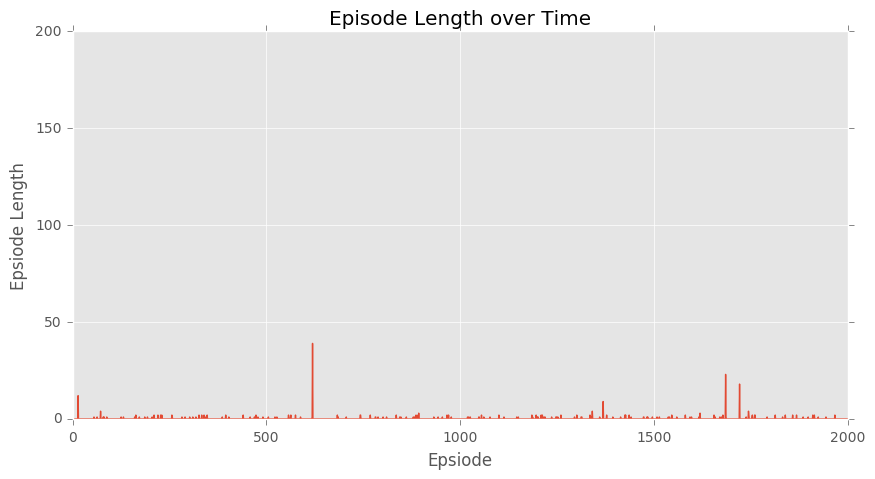

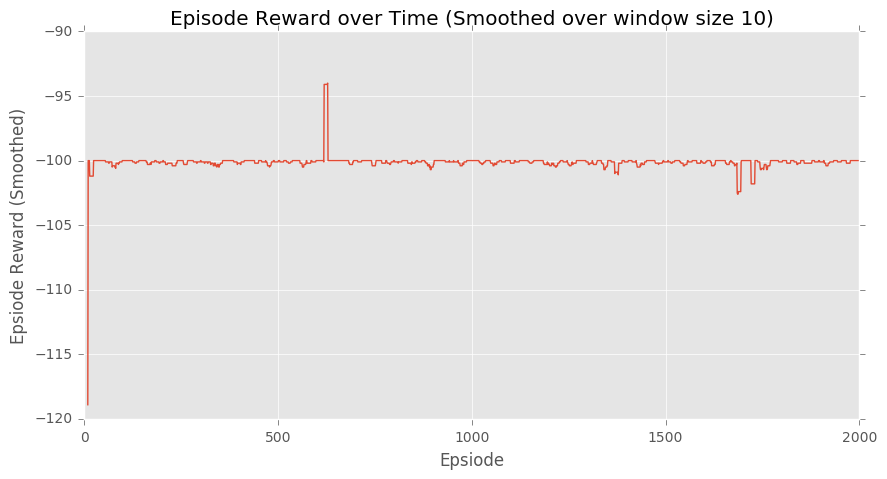

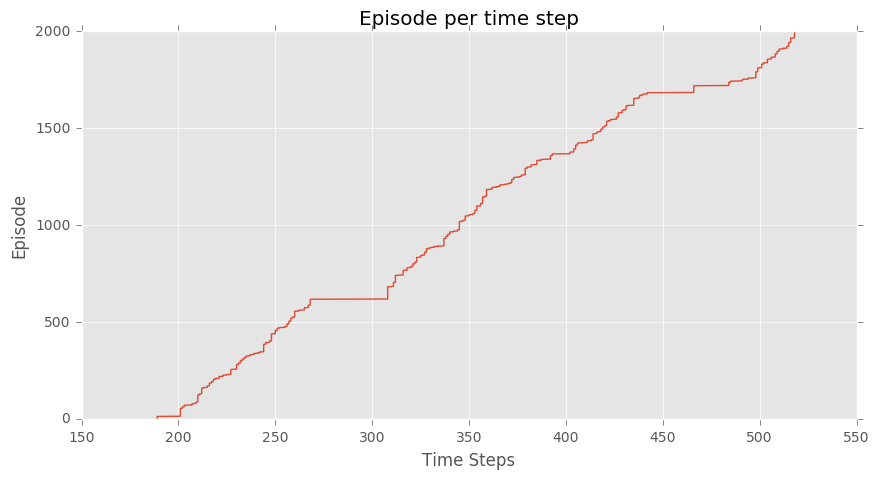

(<matplotlib.figure.Figure at 0x1154cf350>,
 <matplotlib.figure.Figure at 0x11414fe90>)

In [53]:

"""
Sample Statistics done only for expected sarsa for the sake of clarity:

1. Episode length vs Number of episodes
2. Episode average reward vs Number of episodes
3. Number of episodes vs Time


"""

plotting.plot_episode_stats(stats_exp_sarsa)

# The End